In [31]:
import warnings
warnings.filterwarnings('ignore')
import flwr as fl
import numpy as np
import pandas as pd
from typing import Dict
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from typing import Tuple, Union, List
import numpy as np
from sklearn.linear_model import LogisticRegression
import openml
import scipy.stats as stats
import multiprocessing
import time
import pickle
import hashlib
import matplotlib.pyplot as plt
%matplotlib inline

(ecg_fit_alpha, ecg_fit_loc, ecg_fit_beta) = (71.24240868512234, 0.009560726913087843, 0.0016491337124287953)
(rsp_fit_mean, rsp_fit_var) = (2.69587776526746e-06, 0.0007143343551501935)

def generate_labeled_data(n_patients, w1=1, w2=1, w3=1):
    df = pd.DataFrame(
        {"ECG_moy_of_patients": stats.gamma.rvs(ecg_fit_alpha, loc=ecg_fit_loc, scale=ecg_fit_beta, size=n_patients),
         "RSP_moy_of_patients": stats.norm.rvs(rsp_fit_mean, rsp_fit_var, size=n_patients),
         "body_temp_moy_of_patients": stats.norm.rvs(37, 0.5, size=n_patients)})
    df['scale'] = (
        w1*df.ECG_moy_of_patients + 
        w1*df.RSP_moy_of_patients + 
        w1*df.body_temp_moy_of_patients)
    df["status"]=df["scale"].apply(
    lambda x: 0 if (36.5 <= x <= 38.2) 
    else (1 if ((36 <= x < 36.5) or (38.2 < x < 38.5))
    else 2))
    return df

In [32]:
class Block:
    def __init__(self, previous_block_hash, transaction_list):

        self.previous_block_hash = previous_block_hash
        self.transaction_list = transaction_list

        self.block_data = f"{' - '.join(transaction_list)} - {previous_block_hash}"
        self.block_hash = hashlib.sha256(self.block_data.encode()).hexdigest()
init_transact1 = "initiator: server1"
init_transact2 = "strategy: FedAvg"
block1 = Block('Gen', [init_transact1, init_transact2])

class Blockchain:
    def __init__(self):
        self.chain = []
        self.generate_genesis_block()

    def generate_genesis_block(self):
        self.chain.append(Block("0", [init_transact1, init_transact2]))
    
    def create_block_from_transaction(self, transaction_list):
        previous_block_hash = self.last_block.block_hash
        self.chain.append(Block(previous_block_hash, transaction_list))

    def display_chain(self):
        for i in range(len(self.chain)):
            print(f"Data {i + 1}: {self.chain[i].block_data}")
            print(f"Hash {i + 1}: {self.chain[i].block_hash}\n")

    @property
    def last_block(self):
        return self.chain[-1]

fl_blockchain = Blockchain()
fl_blockchain.display_chain()

def load_data(n):
    df = generate_labeled_data(n)
    X = df.drop(['scale', 'status'], axis=1)
    y = df.status
    return X, y
XY = Tuple[np.ndarray, np.ndarray]
Dataset = Tuple[XY, XY]
LogRegParams = Union[XY, Tuple[np.ndarray]]
XYList = List[XY]
def get_model_parameters(model: LogisticRegression) -> LogRegParams:
    if model.fit_intercept:
        params = [
            model.coef_,
            model.intercept_,
        ]
    else:
        params = [
            model.coef_,
        ]
    return params

Data 1: initiator: server1 - strategy: FedAvg - 0
Hash 1: 81d77d0ebf616a09a7e829ea99137db99f505901b8aa5fb369fb22b098fba319



In [33]:
def set_model_params(
    model: LogisticRegression, params: LogRegParams
) -> LogisticRegression:
    model.coef_ = params[0]
    if model.fit_intercept:
        model.intercept_ = params[1]
    return model
def set_initial_params(model: LogisticRegression):
    params = [np.array([[0, 0, 0],[0, 0, 0],[0, 0, 0]]), np.array([5, 8, -12])]
    n_classes = 3
    n_features = 3
    model.classes_ = np.array([i for i in range(n_classes)])

    model.coef_ = np.zeros((n_classes, n_features))
    if model.fit_intercept:
        model.intercept_ = np.array([5, 8, -12])
def set_initial_params_(model: LogisticRegression):
    n_classes = 3
    n_features = 3
    model.classes_ = np.array([i for i in range(n_classes)])

    model.coef_ = np.random.random((n_classes, n_features))
    if model.fit_intercept:
        model.intercept_ = np.random.random((n_classes,))
def shuffle(X: np.ndarray, y: np.ndarray) -> XY:
    """Shuffle X and y."""
    rng = np.random.default_rng()
    idx = rng.permutation(len(X))
    return X[idx], y[idx]
def partition(X: np.ndarray, y: np.ndarray, num_partitions: int) -> XYList:
    """Split X and y into a number of partitions."""
    return list(
        zip(np.array_split(X, num_partitions), np.array_split(y, num_partitions))
    )

In [34]:
(X_train, y_train) = load_data(2000)
(X_test, y_test) = load_data(1000)
(X_train2, y_train2) = load_data(2500)
(X_test2, y_test2) = load_data(1500)
server_validation_data = load_data(1000)
X_train_fk = X_train.copy()
y_train_fk = np.array([0, 1] + [2]*1998)
X_test_fk = X_test.copy()
y_test_fk = np.array([0, 1] + [2]*998)

model = LogisticRegression(
    penalty="l2",
    max_iter=1,
    warm_start=True,
)

In [46]:
from os import getpid, kill
from signal import SIGKILL
from multiprocessing import Lock

In [47]:
k = True
lock = Lock()

def get_pid_dict():
    with open("pids.obj", "rb") as f:
        return pickle.load(f)

def add_pid_model(pid, model):
    d = get_pid_dict()
    d[pid] = model
    with open("pids.obj", "wb") as f:
        pickle.dump(d, f)

def add_current_pid_model(model):
    add_pid_model(getpid(), model)

def get_pid_client_params(pid):
    d = get_pid_dict()
    if pid in d.keys():
        return d[pid]

def ban_mal_clients(X_val, y_val):
    mal_pids=[]
    d = get_pid_dict()
    for pid in d: 
        if d[pid].score(X_val, y_val) < 0.4:
            mal_pids.append(pid)
    return mal_pids
    
def init_clean():
    with open("pids.obj", "wb") as f:
        pickle.dump(dict({}), f)


In [48]:
init_clean()
add_current_pid_model(model)
add_pid_model(4556, model)
get_pid_dict()

{35140: LogisticRegression(), 4556: LogisticRegression()}

In [59]:
class NormalClient(fl.client.NumPyClient):
    def get_parameters(self, config):  # type: ignore
        return get_model_parameters(model)

    def fit(self, parameters, config):  # type: ignore
        (X_train2, y_train2) = load_data(1000)
        set_model_params(model, parameters)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            model.fit(X_train2, y_train2)

        with lock:
            add_current_pid_model(model)

        fl_blockchain.create_block_from_transaction(
            ['client2_model_params: '+str(get_model_parameters(model)),
            'model_pkl_object_location: client2.obj']
            )

        return get_model_parameters(model), len(X_train2), {}

    def evaluate(self, parameters, config):  # type: ignore
        
        set_model_params(model, parameters)
        loss = log_loss(y_test2, model.predict_proba(X_test2))
        accuracy = model.score(X_test2, y_test2)
        return loss, len(X_test2), {"accuracy": accuracy}

In [60]:
class MaliciousClient1(fl.client.NumPyClient):
    def get_parameters(self, config):  # type: ignore
        return get_model_parameters(model)

    def fit(self, parameters, config):  # type: ignore
        set_model_params(model, parameters)
        n = 1800
        X_train_fk, _ = load_data(n)
        y_train_fk = np.array([0, 1] + [2]*(n-2))
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            model.fit(X_train_fk, y_train_fk)
        
        with lock:
            add_current_pid_model(model)

        fl_blockchain.create_block_from_transaction(
            ['client3_model_params: '+str(get_model_parameters(model)),
            'model_pkl_object_location: client3.obj']
            )

        return get_model_parameters(model), len(X_train_fk), {}

    def evaluate(self, parameters, config):  # type: ignore
        n = 1800
        X_test_fk, _ = load_data(n)
        y_test_fk = np.array([0, 1] + [2]*(n-2))
        set_model_params(model, parameters)
        loss = log_loss(y_test_fk, model.predict_proba(X_test_fk))
        accuracy = model.score(X_test_fk, y_test_fk)
        return loss, len(X_test_fk), {"accuracy": accuracy}

In [61]:
class MaliciousClient2(fl.client.NumPyClient):
    def get_parameters(self, config):  # type: ignore
        return get_model_parameters(model)

    def fit(self, parameters, config):  # type: ignore
        set_model_params(model, parameters)
        n = 1800
        X_train_fk, _ = load_data(n)
        y_train_fk = np.array([0, 1] + [2]*(n-2))
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            model.fit(X_train_fk, y_train_fk)

        with lock:
            add_current_pid_model(model)

        fl_blockchain.create_block_from_transaction(
            ['client4_model_params: '+str(get_model_parameters(model)),
            'model_pkl_object_location: client4.obj']
            )

        return get_model_parameters(model), len(X_train_fk), {}

    def evaluate(self, parameters, config):  # type: ignore
        n = 1800
        X_test_fk, _ = load_data(n)
        y_test_fk = np.array([0, 1] + [2]*(n-2))
        set_model_params(model, parameters)
        loss = log_loss(y_test_fk, model.predict_proba(X_test_fk))
        accuracy = model.score(X_test_fk, y_test_fk)
        return loss, len(X_test_fk), {"accuracy": accuracy}

In [62]:
def fit_round(server_round: int) -> Dict:
    """Send round number to client."""
    return {"server_round": server_round}

def get_evaluate_fn_server1(model: LogisticRegression):
    """Return an evaluation function for server-side evaluation."""

    # Load test data here to avoid the overhead of doing it in `evaluate` itself
    X_test, y_test = server_validation_data
    # The `evaluate` function will be called after every round
    def evaluate(server_round, parameters: fl.common.NDArrays, config):
        # Update model with the latest parameters
        set_model_params(model, parameters)
        loss = log_loss(y_test, model.predict_proba(X_test))
        accuracy = model.score(X_test, y_test)

        ### here the malicious clients should be banned
        if k:
            with lock:
                malicious_clients_pids = ban_mal_clients(X_test, y_test)
                for pid in malicious_clients_pids:
                    try:
                        kill(pid, SIGKILL)
                    except:
                        None

        return loss, {"accuracy": accuracy}

    return evaluate

def get_evaluate_fn_server2(model: LogisticRegression):
    X_test, y_test = server_validation_data
    def evaluate(server_round, parameters: fl.common.NDArrays, config):
        set_model_params(model, parameters)
        loss = log_loss(y_test, model.predict_proba(X_test))
        accuracy = model.score(X_test, y_test)

        return loss, {"accuracy": accuracy}
        
    return evaluate
    
# Start Flower server for five rounds of federated learning
model = LogisticRegression()
set_initial_params(model)
strategy_server1 = fl.server.strategy.FedAvg(
    min_available_clients=4,
    evaluate_fn=get_evaluate_fn_server1(model),
    on_fit_config_fn=fit_round,
)

fl_blockchain.create_block_from_transaction(
    ['server1_strategy: FedAvg',
    'server1_min_available_clients: 2'],
)

strategy_server2 = fl.server.strategy.FedAvg(
    min_available_clients=4,
    evaluate_fn=get_evaluate_fn_server2(model),
    on_fit_config_fn=fit_round,
)

fl_blockchain.create_block_from_transaction(
    ['server2_strategy: FedAvg',
    'server2_min_available_clients: 2'],
)

In [81]:
def runserver1():
    hist = fl.server.start_server(
        server_address="0.0.0.0:8080",
        strategy=strategy_server1,
        config=fl.server.ServerConfig(num_rounds=6),
        )
    h = open('flwr_hist1.obj', 'wb')
    pickle.dump(hist.metrics_centralized,h)
    h.close()

def runserver2():
    hist = fl.server.start_server(
        server_address="0.0.0.0:8080",
        strategy=strategy_server2,
        config=fl.server.ServerConfig(num_rounds=6),
        )
    h = open('flwr_hist2.obj', 'wb')
    pickle.dump(hist.metrics_centralized,h)
    h.close()

def runserver():
    hist = fl.server.start_server(
        server_address="0.0.0.0:8080",
        strategy=strategy_server1,
        config=fl.server.ServerConfig(num_rounds=16),
        )
    h = open('flwr_hist.obj', 'wb')
    pickle.dump(hist.metrics_centralized,h)
    h.close()

In [82]:
def runclient1():
    fl.client.start_numpy_client(server_address="0.0.0.0:8080", client=NormalClient())
def runclient2():
    fl.client.start_numpy_client(server_address="0.0.0.0:8080", client=NormalClient())
def runclient3():
    fl.client.start_numpy_client(server_address="0.0.0.0:8080", client=MaliciousClient1())
def runclient4():
    fl.client.start_numpy_client(server_address="0.0.0.0:8080", client=MaliciousClient2())


In [83]:
def start_fl():
    init_clean()
    multiprocessing.Process(target=runserver).start()
    time.sleep(0.5)
    multiprocessing.Process(target=runclient3).start()
    multiprocessing.Process(target=runclient4).start()
    multiprocessing.Process(target=runclient2).start()
    multiprocessing.Process(target=runclient1).start()
    multiprocessing.Process(target=runclient2).start()
    multiprocessing.Process(target=runclient1).start()

In [84]:
k = False
p = multiprocessing.Process(target=start_fl)
p.start()
while p.is_alive():
    time.sleep(2)
ev = open(f'flwr_hist.obj', 'rb')
a = pickle.load(ev)['accuracy']
accuracy1 = [t[1] for t in a]
ev.close()
k = True
p = multiprocessing.Process(target=start_fl)
p.start()
while p.is_alive():
    time.sleep(2)
ev = open(f'flwr_hist.obj', 'rb')
a = pickle.load(ev)['accuracy']
accuracy2 = [t[1] for t in a]
ev.close()

INFO flower 2022-09-09 21:18:38,761 | app.py:119 | Starting Flower server, config: ServerConfig(num_rounds=16, round_timeout=None)
INFO flower 2022-09-09 21:18:38,803 | app.py:132 | Flower ECE: gRPC server running (16 rounds), SSL is disabled
INFO flower 2022-09-09 21:18:38,809 | server.py:86 | Initializing global parameters
INFO flower 2022-09-09 21:18:38,812 | server.py:270 | Requesting initial parameters from one random client
INFO flower 2022-09-09 21:18:39,302 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
INFO flower 2022-09-09 21:18:39,296 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-09-09 21:18:39,337 | connection.py:39 | ChannelConnectivity.IDLE
INFO flower 2022-09-09 21:18:39,339 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-09-09 21:18:39,393 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-09-09 21:18:39,418 | s

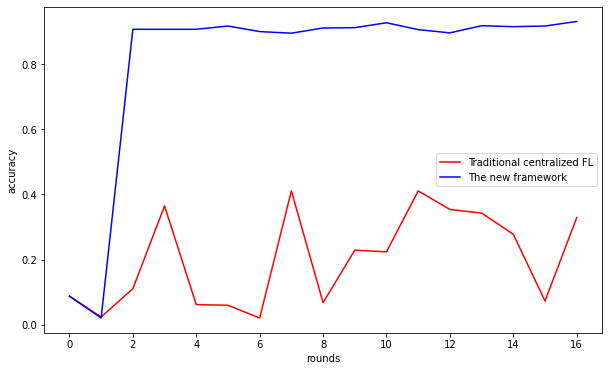

In [92]:
plt.rcParams["figure.figsize"] = (10,6)
plt.plot(accuracy1[0:], color='red', label="Traditional centralized FL")
plt.plot(accuracy2[0:], color='blue', label="The new framework")
plt.xlabel("rounds")
plt.ylabel("accuracy")
plt.legend(loc=5)
plt.savefig("comp.pdf")
plt.show()